In [1]:
# Manejo de datos
##Leer CSV
import pandas as pd
import numpy as np
from optparse import OptionParser
import sys
from time import time
# Para procesar los datos 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
#nltk.download('stopwords')
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')



# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel


# DL
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

#Metricas de precision
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')



op = OptionParser()




In [2]:
##Archivo de lectura
df = pd.read_csv('Dataset/spam_ham_dataset.csv')
# Quitamos columnas innecesarias
df.drop('Unnamed: 0', axis=1, inplace = True)
# Cambiamos el nombre de las columnas 
df.columns = ['etiqueta', 'texto', 'clase']

In [3]:
##mostramos cabecera con los datos
df.head(10)


,etiqueta,texto,clase
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,ham,Subject: ehronline web address change\r\nthis ...,0
6,ham,Subject: spring savings certificate - take 30 ...,0
7,spam,Subject: looking for medication ? we ` re the ...,1
8,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [4]:
print(f'El dataset tiene un total de {df.shape[0]} E-Mails, pueden categorizarse en ham y spam')

El dataset tiene un total de 5171 E-Mails, pueden categorizarse en ham y spam


<AxesSubplot:xlabel='etiqueta', ylabel='count'>

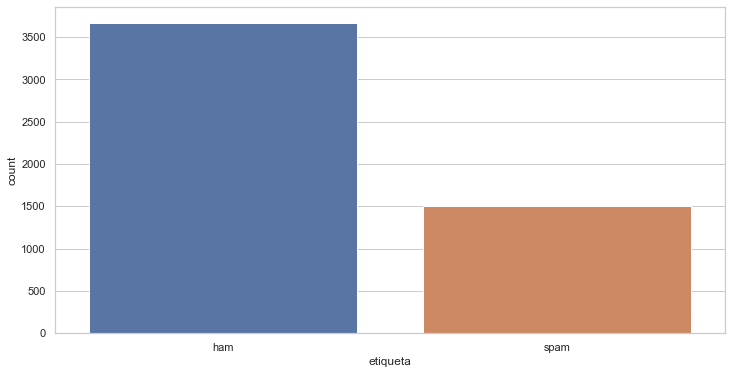

In [5]:
plt.figure(figsize = (12, 6))
sns.set_theme(style="whitegrid")

sns.countplot(data = df, x = 'etiqueta')

In [6]:
#limpiamos los datos

stop_words = set(stopwords.words('english')) 

df['texto'] = df['texto'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

In [7]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
#Limpiamos el texto con RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

In [8]:
df['texto'] = df['texto'].apply(lambda string: clean_str(string))
#Mostramos los datos en limpio
df.head()


,etiqueta,texto,clase
0,ham,subject enron methanol meter follow note gave ...,0
1,ham,subject hpl nom january see attached file hpln...,0
2,ham,subject neon retreat ho ho ho around wonderful...,0
3,spam,subject photoshop windows office cheap main tr...,1
4,ham,subject indian springs deal book teco pvr reve...,0


In [9]:
# Convertir una colección de documentos de texto en una matriz de recuentos de tokens
from sklearn.feature_extraction.text import CountVectorizer
vectorizador = CountVectorizer()
X = vectorizador.fit_transform(df.texto)

y = df.etiqueta



In [10]:
#Dividir arreglos o matrices en subconjuntos de prueba y entrenamiento aleatorio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle = True)


In [11]:
print(f"NÚMERO DE OBSERVACIONES: {X.shape[0]}\nTOKENS: {X.shape[1]}")


NÚMERO DE OBSERVACIONES: 5171
TOKENS: 45595


In [12]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
def benchmark(clf):
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0

    score = metrics.accuracy_score(y_test, pred)
    print("Entrenando: ",clf,"Tiempo de entrenamiento",train_time,"Exactitud",score)
   
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    # entrenando Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # entrenando SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# entrenando SGD con Elastic Net penalty
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# entrenando  without threshold
results.append(benchmark(NearestCentroid()))

#Algoritmos basados en Naive Bayes
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))


results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))



Entrenando:  RidgeClassifier(solver='sag', tol=0.01) Tiempo de entrenamiento 0.3210330009460449 Exactitud 0.8154589371980676

Entrenando:  Perceptron(max_iter=50) Tiempo de entrenamiento 0.015958786010742188 Exactitud 0.9739130434782609

Entrenando:  PassiveAggressiveClassifier(max_iter=50) Tiempo de entrenamiento 0.0219423770904541 Exactitud 0.970048309178744

Entrenando:  KNeighborsClassifier(n_neighbors=10) Tiempo de entrenamiento 0.003995418548583984 Exactitud 0.7971014492753623

Entrenando:  RandomForestClassifier() Tiempo de entrenamiento 4.305150508880615 Exactitud 0.9768115942028985

Entrenando:  LinearSVC(dual=False, tol=0.001) Tiempo de entrenamiento 0.05586695671081543 Exactitud 0.970048309178744

Entrenando:  SGDClassifier(max_iter=50) Tiempo de entrenamiento 0.0 Exactitud 0.9729468599033816

Entrenando:  LinearSVC(dual=False, penalty='l1', tol=0.001) Tiempo de entrenamiento 0.16135001182556152 Exactitud 0.966183574879227

Entrenando:  SGDClassifier(max_iter=50, penalty='l1

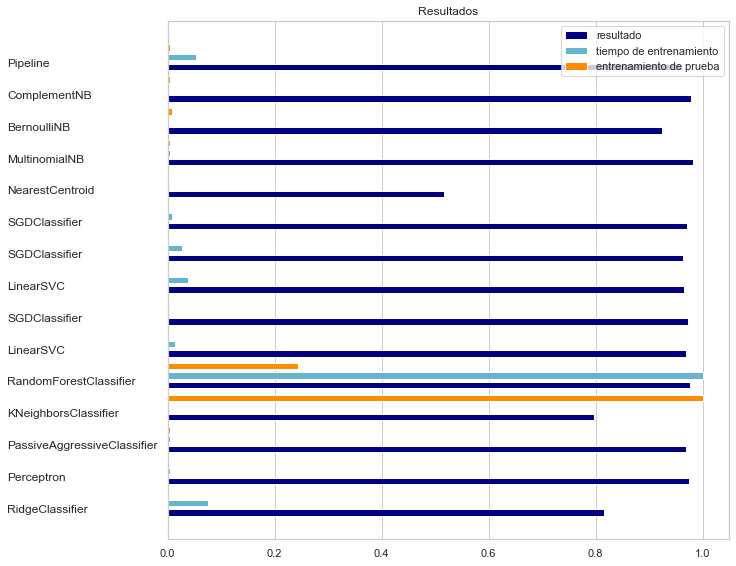

In [13]:
##Crear grafico con los resultados

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Resultados")
plt.barh(indices, score, .2, label="resultado", color='navy')
plt.barh(indices + .3, training_time, .2, label="tiempo de entrenamiento",
         color='c')
plt.barh(indices + .6, test_time, .2, label="entrenamiento de prueba", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [14]:
# Busca el mejor hyperparameter con RandomizedSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import RandomizedSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False],"norm": [True, False]}

grid = RandomizedSearchCV(ComplementNB(), parameters,random_state=0)
grid.fit(X_train,y_train)

print("Mejores hyperparametros :",grid.best_params_)
print("Exactitud :",grid.best_score_)

# Crea un DataFrame con el mejor Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

Mejores hyperparametros : {'norm': False, 'fit_prior': True, 'alpha': 0.2}
Exactitud : 0.9792074841257323


,params,mean_test_score
1,"{'norm': False, 'fit_prior': True, 'alpha': 0.2}",0.979207
7,"{'norm': False, 'fit_prior': True, 'alpha': 5}",0.964458
2,"{'norm': False, 'fit_prior': False, 'alpha': 10}",0.945599
5,"{'norm': False, 'fit_prior': True, 'alpha': 10}",0.945599
6,"{'norm': True, 'fit_prior': False, 'alpha': 1}",0.910299
8,"{'norm': True, 'fit_prior': True, 'alpha': 1}",0.910299
3,"{'norm': True, 'fit_prior': True, 'alpha': 2}",0.908607
4,"{'norm': True, 'fit_prior': False, 'alpha': 2}",0.908607
9,"{'norm': True, 'fit_prior': False, 'alpha': 0.2}",0.894825
0,"{'norm': True, 'fit_prior': False, 'alpha': 10}",0.883946


In [15]:
# Crea un modelo con hyperparameters
from sklearn.naive_bayes import ComplementNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = ComplementNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)



In [16]:
##Enseñamos predicción
from sklearn.metrics import classification_report, accuracy_score
print(f'## Exactitud: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

## Exactitud: 97.89999999999999%



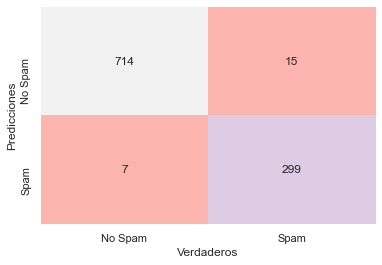

In [17]:
cmat = confusion_matrix(y_test, y_pred)
grafica=sns.heatmap(cmat, annot = True, cmap = 'Pastel1', cbar = False, fmt="d", xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

grafica.set(xlabel='Verdaderos', ylabel='Predicciones')
plt.show()

In [18]:
def mostar_resultado(df, number=2):
    for i in range(number):
        msg = df['texto'].iloc[i]
        label = df["etiqueta"].iloc[i]
        msg_vec = vectorizador.transform([msg])
        pred_label = model.predict(msg_vec)
        print(f"**Real: {label}, Prediccion: {pred_label[0]}**")
    



In [19]:
df_spam = df[(df['etiqueta'] == 'spam') & (df['clase'] == 1) ]
df_ham = df[(df['etiqueta'] == 'ham') & (df['clase'] == 0) ]
mostar_resultado(df_spam)
mostar_resultado(df_ham)

**Real: spam, Prediccion: spam**
**Real: spam, Prediccion: spam**
**Real: ham, Prediccion: ham**
**Real: ham, Prediccion: ham**


In [20]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense


##Capa visible 1 entrada 
input_dim = 1
model_red = Sequential()
model_red.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
model_red.add(Dense(8, activation='relu'))
model_red.add(layers.Dense(1, activation='sigmoid'))


In [21]:
model_red.compile(loss='binary_crossentropy', 
              optimizer='adamax', 
              metrics=['accuracy'])
model_red.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [22]:
Xt = df.texto

y = df.etiqueta

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

X1 = np.array(label_encoder.fit_transform(Xt))
y1 = np.array(label_encoder.fit_transform(y))




In [23]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=11)




In [24]:
X_train1=np.array(X_train1)
y_train1=np.array(y_train1)


In [25]:
history = model_red.fit(X_train1, 
                        y_train1,
                    epochs=1500,
                    verbose=False,
                    validation_data=(X_test1, y_test1),
                    batch_size=10)

prediccion=model_red.predict(X_train1)

print("predictions shape:", prediccion.shape)

predictions shape: (4136, 1)


In [26]:
loss, accuracy = model_red.evaluate(X_train1, y_train1, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model_red.evaluate(X_test1, y_test1, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))


Precisión Entrenamiento: 0.7140
Precisión Prueba:  0.7217


In [27]:
# evalua el modelo
scores = model_red.evaluate(X_train1, y_train1)
print("\n%s: %.2f%%" % (model_red.metrics_names[1], scores[1]*100))

130/130 [==============================] - 0s 417us/step - loss: 0.5970 - accuracy: 0.7140

accuracy: 71.40%


In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento prec')
    plt.plot(x, val_acc, 'r', label='Validacion prec')
    plt.title('Precision Entrenamiento y validacion')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perdida Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Perdida Validacion')
    plt.title('Perdida Entrenamiento y validacion')
    plt.legend()
    plt.show()

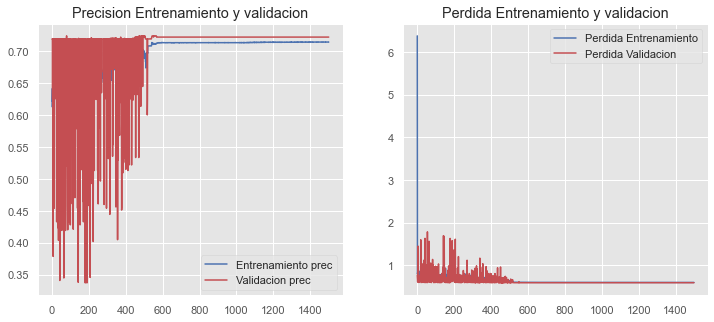

In [29]:
plot_history(history)


In [30]:
print(f'## Exactitud ComplementNB: {round(accuracy_score(y_test,y_pred),3)*100}%\n')
print(f'## Exactitud red neuronal: {(model_red.metrics_names[1], scores[1]*100)}%\n')
print("\n%s: %.2f%%" % (model_red.metrics_names[1], scores[1]*100))

## Exactitud ComplementNB: 97.89999999999999%

## Exactitud red neuronal: ('accuracy', 71.39748334884644)%


accuracy: 71.40%


In [31]:
df_spam.to_csv('Dataset/leidos_spam.csv', sep='\t')